<a href="https://colab.research.google.com/github/cal-robinson/HAD7001_IntrotoML/blob/main/5_HAD7001_S25.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Import libraries**

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, roc_auc_score, roc_curve
from sklearn.preprocessing import StandardScaler, LabelEncoder
import seaborn as sns
import warnings
import statsmodels.api as sm
from scipy.stats import boxcox
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error

warnings.filterwarnings('ignore')

**Import the dataset**

In [9]:
from google.colab import files
import pandas as pd
import io
uploaded = files.upload()

data = pd.read_csv('Datathon #2 Heart Failure Mortality.csv')

Saving Datathon #2 Heart Failure Mortality.csv to Datathon #2 Heart Failure Mortality.csv


**Explore the dataset**

In [10]:
data
print(data.dtypes)
data.head(n=10)
pd.crosstab(data['hf_mortality'], columns='count')

age                         float64
anaemia                       int64
creatinine_phosphokinase      int64
diabetes                      int64
ejection_fraction             int64
hypertension                  int64
platelets                   float64
serum_creatinine            float64
serum_sodium                  int64
sex                           int64
smoking                       int64
time                          int64
hf_mortality                  int64
dtype: object


col_0,count
hf_mortality,
0,203
1,96


Explore missing data

In [11]:
missing_data = print(data.isna())
missing_count = data.isna().sum()
print(missing_data)
print(missing_count)
# No missing data present

       age  anaemia  creatinine_phosphokinase  diabetes  ejection_fraction  \
0    False    False                     False     False              False   
1    False    False                     False     False              False   
2    False    False                     False     False              False   
3    False    False                     False     False              False   
4    False    False                     False     False              False   
..     ...      ...                       ...       ...                ...   
294  False    False                     False     False              False   
295  False    False                     False     False              False   
296  False    False                     False     False              False   
297  False    False                     False     False              False   
298  False    False                     False     False              False   

     hypertension  platelets  serum_creatinine  serum_sodium   

Check class imbalance and distributions

Variable 'anemia' skipped (likely not categorical).


Class imbalance in 'diabetes':
diabetes
0    0.58194
1    0.41806
Name: proportion, dtype: float64


Class imbalance in 'hypertension':
hypertension
0    0.648829
1    0.351171
Name: proportion, dtype: float64


Class imbalance in 'sex':
sex
1    0.648829
0    0.351171
Name: proportion, dtype: float64


Class imbalance in 'smoking':
smoking
0    0.67893
1    0.32107
Name: proportion, dtype: float64


Variable '90-day mortality' skipped (likely not categorical).


Variable '30-day mortality' skipped (likely not categorical).




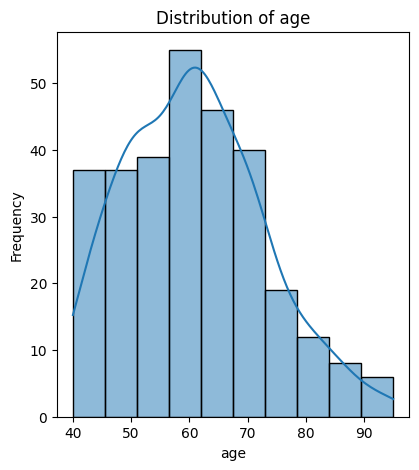

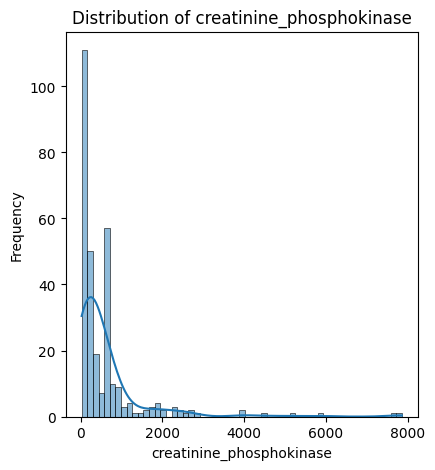

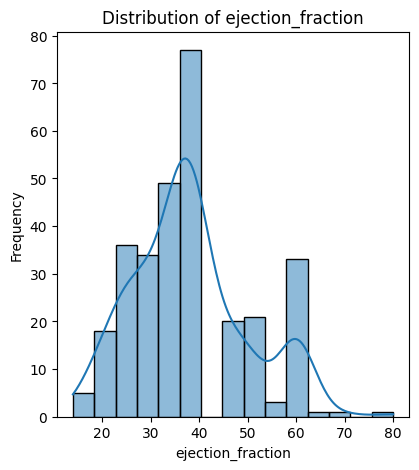

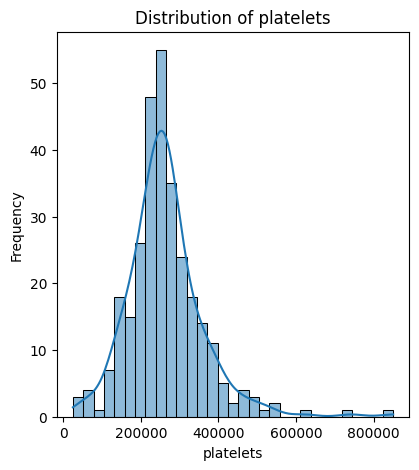

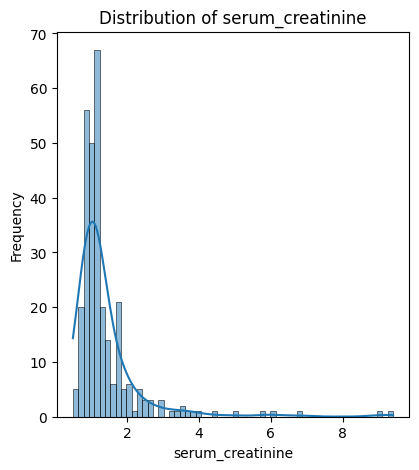

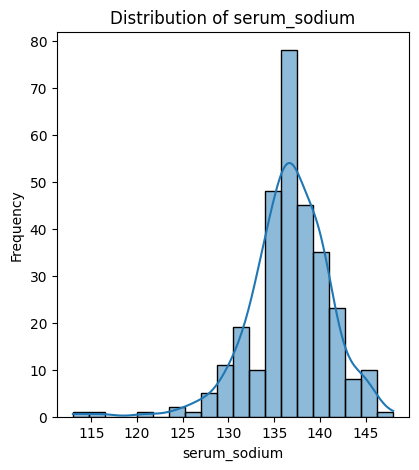

<Figure size 800x600 with 0 Axes>

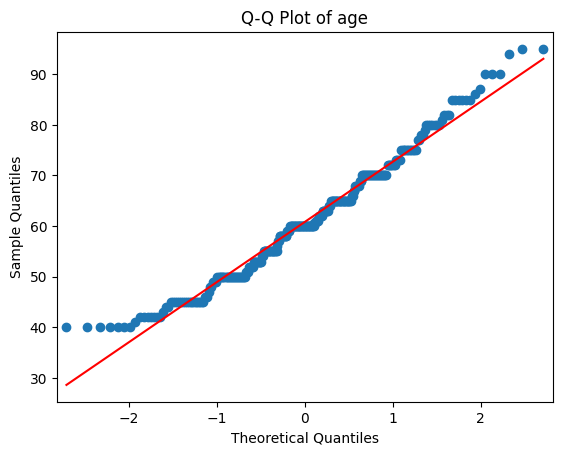

<Figure size 800x600 with 0 Axes>

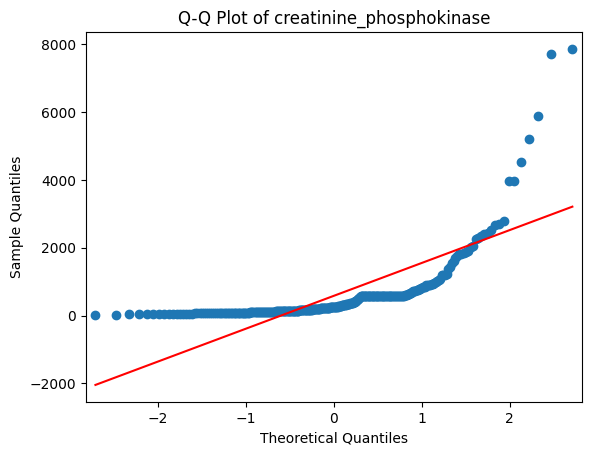

<Figure size 800x600 with 0 Axes>

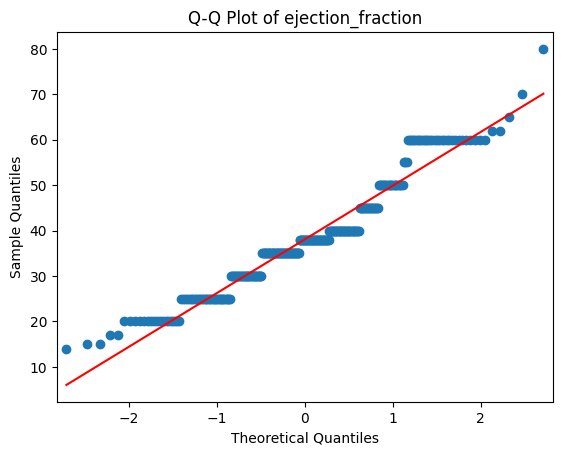

<Figure size 800x600 with 0 Axes>

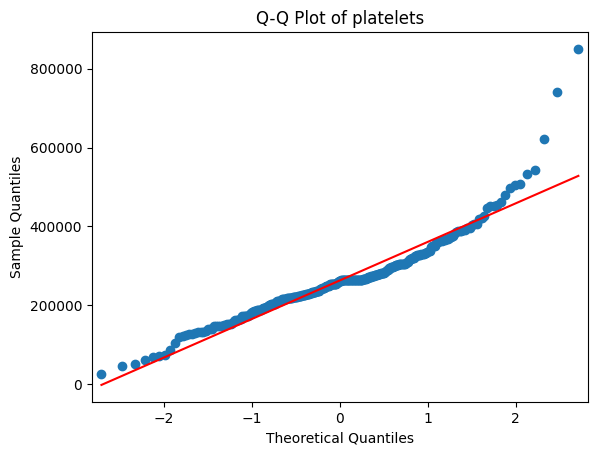

<Figure size 800x600 with 0 Axes>

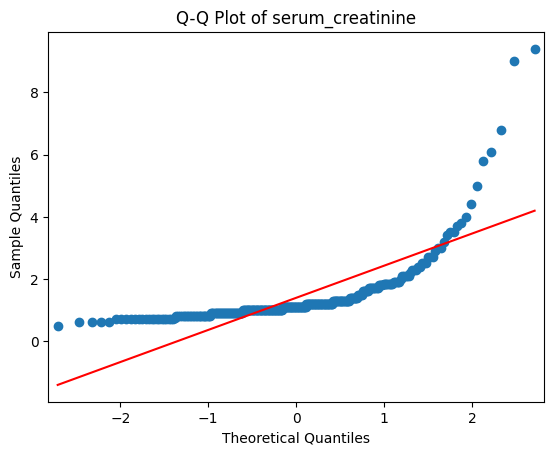

<Figure size 800x600 with 0 Axes>

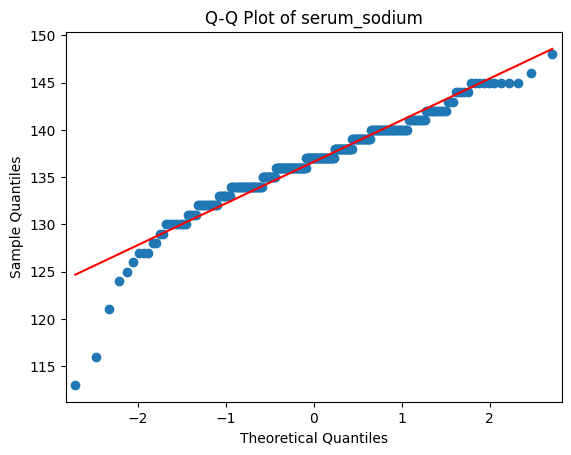

In [12]:
# Check for class imbalance for categorical variables
def check_class_imbalance(data, target_variable):
  class_counts = data[target_variable].value_counts(normalize=True)
  return class_counts

categorical_vars = ['anemia','diabetes','hypertension','sex','smoking','90-day mortality', '30-day mortality']

# Loop through all variables and check for class imbalance
for variable in categorical_vars:
    try:
        imbalance_report = check_class_imbalance(data, variable)
        print(f"Class imbalance in '{variable}':")
        print(imbalance_report)
        print("\n")  # Add a separator between variables
    except KeyError:
        print(f"Variable '{variable}' skipped (likely not categorical).")
        print("\n")

# Assess distribution of continuous variables
continuous_vars = ['age', 'creatinine_phosphokinase', 'ejection_fraction',
                   'platelets', 'serum_creatinine', 'serum_sodium']

for var in continuous_vars:
    plt.figure(figsize=(10, 5))  # Adjust figure size if needed

    # Histogram
    plt.subplot(1, 2, 1)
    sns.histplot(data[var], kde=True)  # kde adds a kernel density estimate
    plt.title(f'Distribution of {var}')
    plt.xlabel(var)
    plt.ylabel('Frequency')

# Assess distribution of residuals
for var in continuous_vars:
    plt.figure(figsize=(8, 6))

    # Q-Q plot
    sm.qqplot(data[var], line='s')  # 's' for standardized line
    plt.title(f'Q-Q Plot of {var}')
    plt.xlabel('Theoretical Quantiles')
    plt.ylabel('Sample Quantiles')

    plt.show()

Descriptive data - overall cohort

In [13]:
print(data.describe())
descriptivegroup = data.groupby('hf_mortality').mean()
print(descriptivegroup)

descriptivesd = data.groupby('hf_mortality').std()
print(descriptivesd)

freq_anemia = pd.crosstab(data['anaemia'], data['hf_mortality'])
print(freq_anemia)

freq_diab = pd.crosstab(data['diabetes'], data['hf_mortality'])
print(freq_diab)

freq_htn = pd.crosstab(data['hypertension'], data['hf_mortality'])
print(freq_htn)

freq_sex = pd.crosstab(data['sex'], data['hf_mortality'])
print(freq_sex)

freq_smoke = pd.crosstab(data['smoking'], data['hf_mortality'])
print(freq_smoke)

              age     anaemia  creatinine_phosphokinase    diabetes  \
count  299.000000  299.000000                299.000000  299.000000   
mean    60.833893    0.431438                581.839465    0.418060   
std     11.894809    0.496107                970.287881    0.494067   
min     40.000000    0.000000                 23.000000    0.000000   
25%     51.000000    0.000000                116.500000    0.000000   
50%     60.000000    0.000000                250.000000    0.000000   
75%     70.000000    1.000000                582.000000    1.000000   
max     95.000000    1.000000               7861.000000    1.000000   

       ejection_fraction  hypertension      platelets  serum_creatinine  \
count         299.000000    299.000000     299.000000         299.00000   
mean           38.083612      0.351171  263358.029264           1.39388   
std            11.834841      0.478136   97804.236869           1.03451   
min            14.000000      0.000000   25100.000000       

Visualize outcome data

Text(0.5, 1.0, 'Distribution of Heart Failure Mortality')

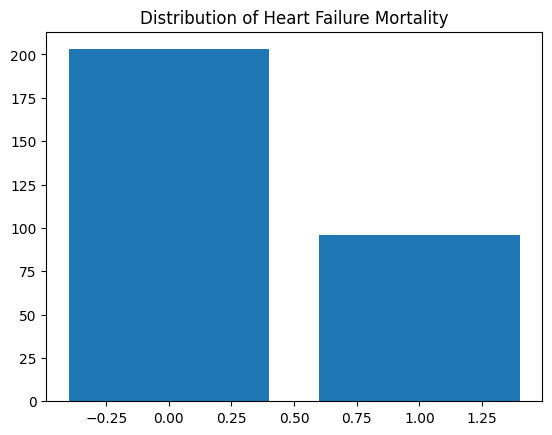

In [14]:
plt.hist(data['hf_mortality'], bins = [-0.5, 0.5, 1.5], rwidth = 0.8)
plt.title('Distribution of Heart Failure Mortality')

Visualize outlier data

In [15]:
import plotly.express as px  # Import Plotly Express
px.histogram(data, x='age')

In [16]:
px.histogram(data, x='creatinine_phosphokinase')

In [17]:
px.histogram(data, x='ejection_fraction')

In [18]:
px.histogram(data, x='platelets')

In [19]:
px.histogram(data, x='serum_creatinine')

In [20]:
px.histogram(data, x='serum_sodium')

Correlation plot of variables - check for collinearity

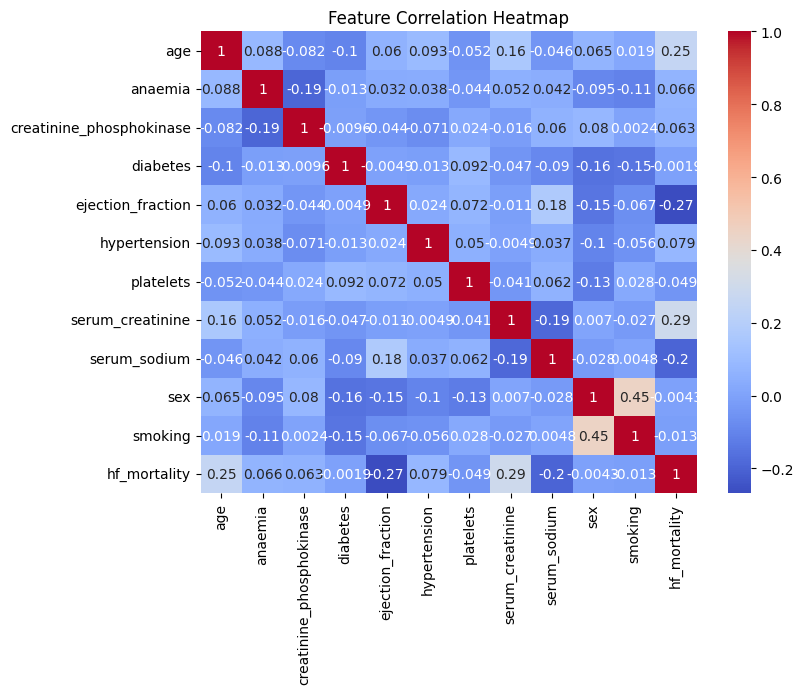

In [21]:
corr_data = pd.DataFrame(data, columns=['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes', 'ejection_fraction', 'hypertension', 'platelets', 'serum_creatinine', 'serum_sodium', 'sex', 'smoking', 'hf_mortality'])

plt.figure(figsize=(8,6))
sns.heatmap(corr_data.corr(), annot=True, cmap='coolwarm')
plt.title("Feature Correlation Heatmap")
plt.show()

Data visualization with pair plot

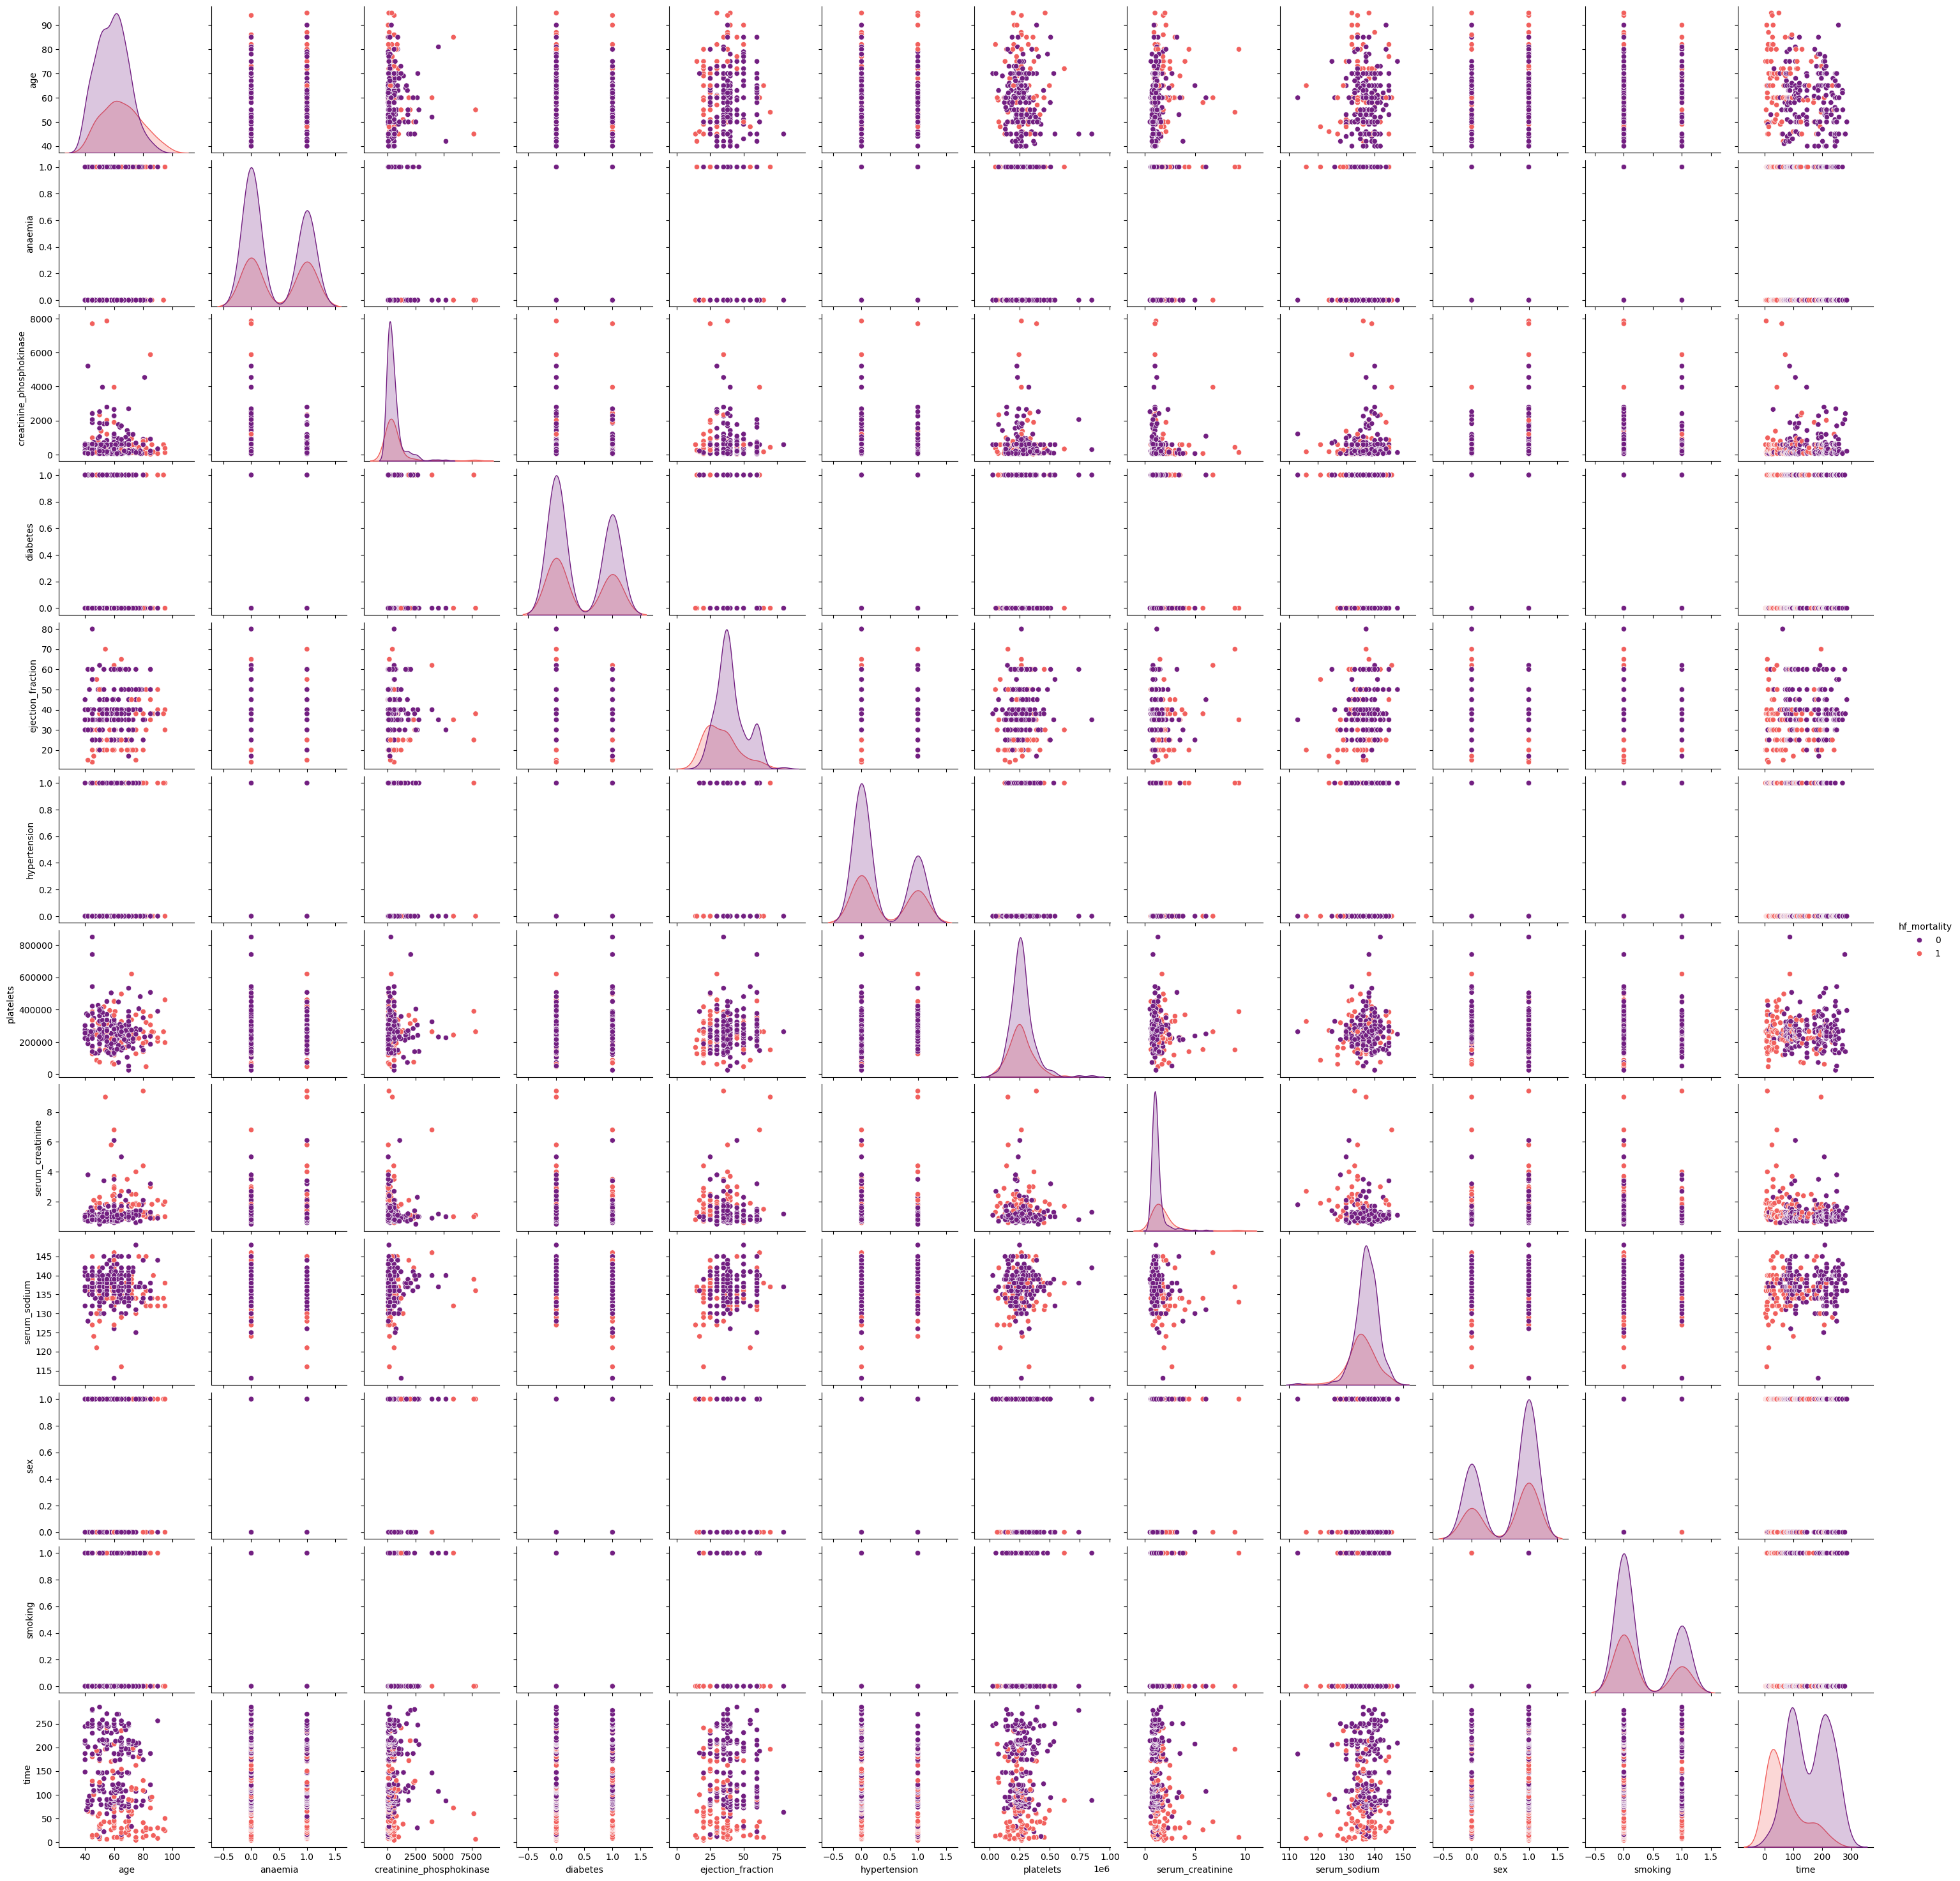

In [22]:
sns.pairplot(data, hue='hf_mortality', palette="magma")
plt.show()

**Data preparation for analysis**

In [23]:
list(data.columns)

['age',
 'anaemia',
 'creatinine_phosphokinase',
 'diabetes',
 'ejection_fraction',
 'hypertension',
 'platelets',
 'serum_creatinine',
 'serum_sodium',
 'sex',
 'smoking',
 'time',
 'hf_mortality']

Transform non-normal data

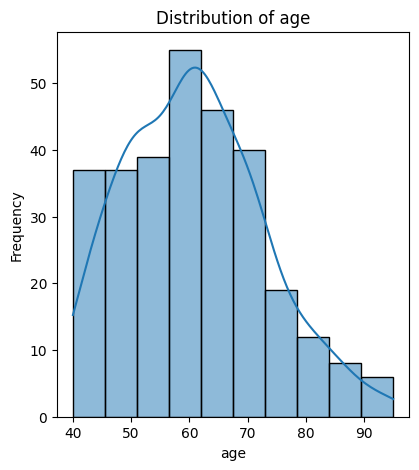

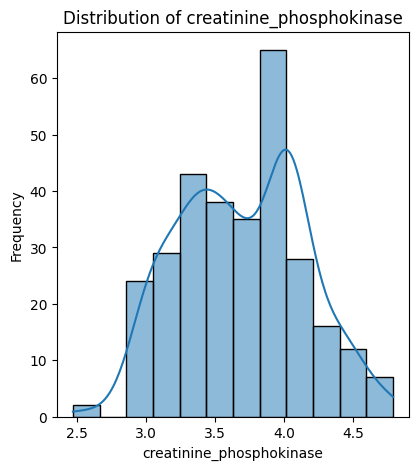

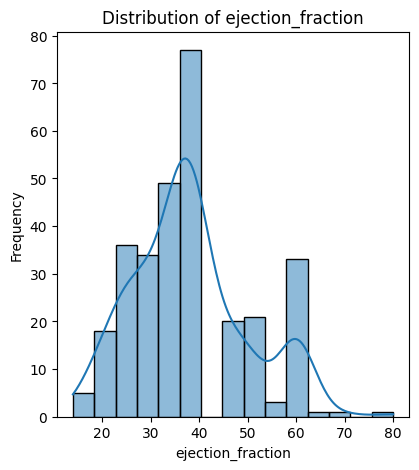

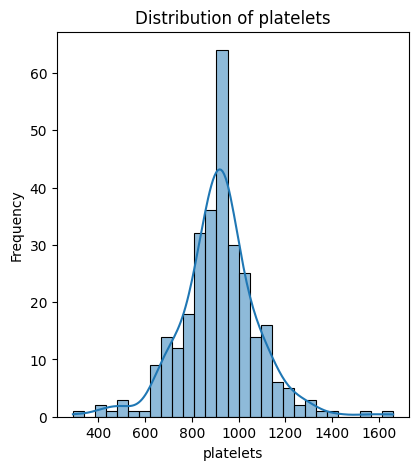

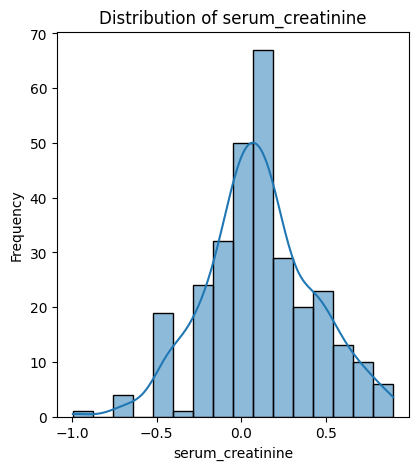

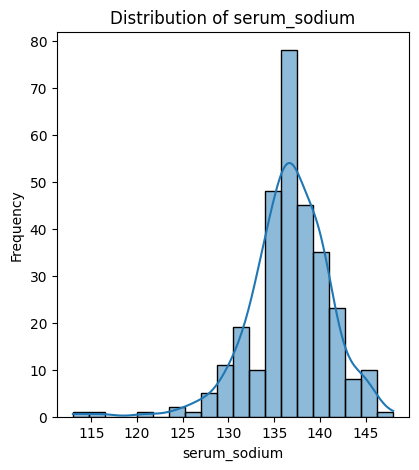

<Figure size 800x600 with 0 Axes>

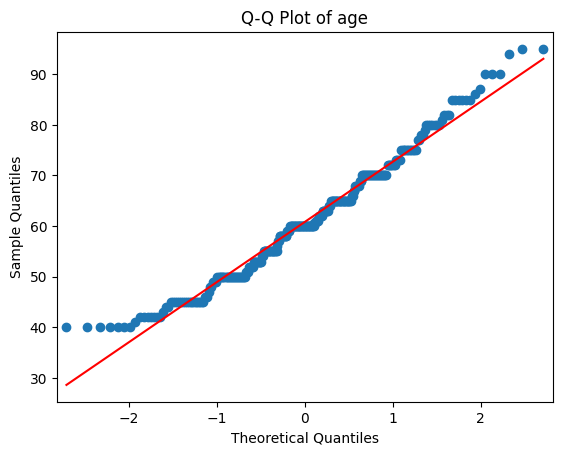

<Figure size 800x600 with 0 Axes>

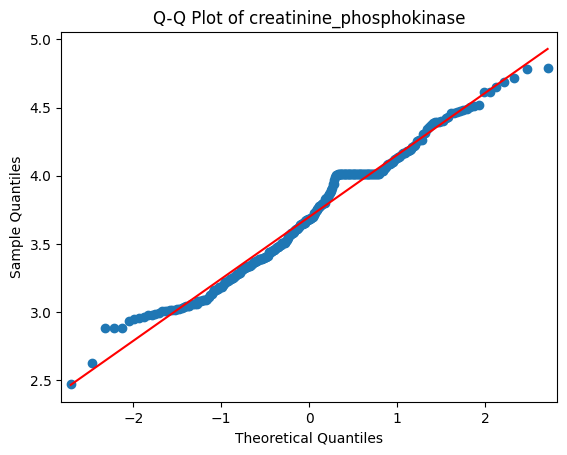

<Figure size 800x600 with 0 Axes>

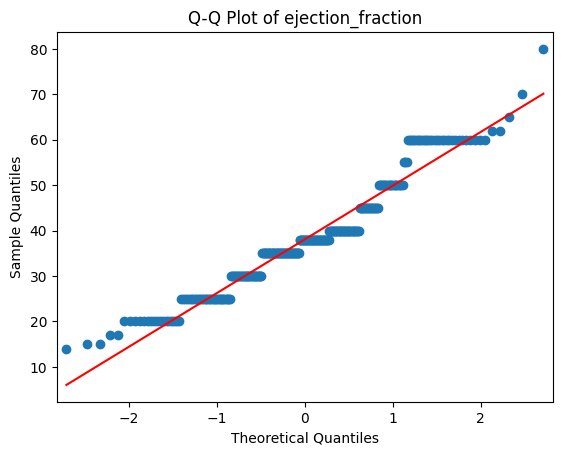

<Figure size 800x600 with 0 Axes>

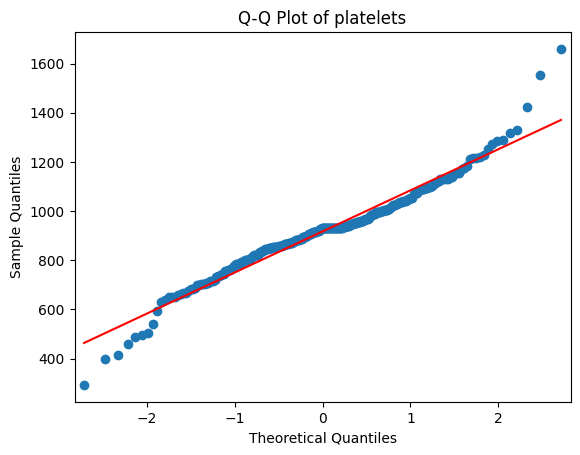

<Figure size 800x600 with 0 Axes>

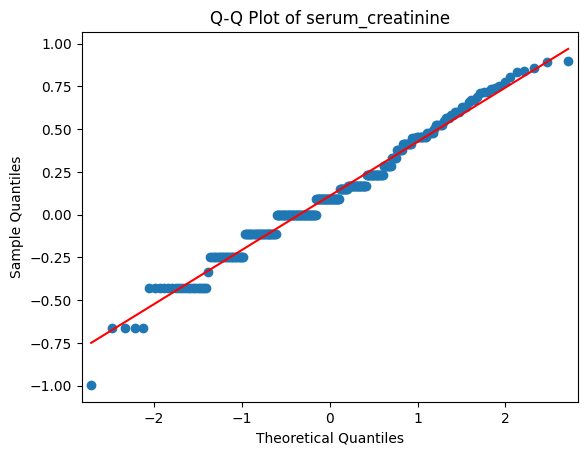

<Figure size 800x600 with 0 Axes>

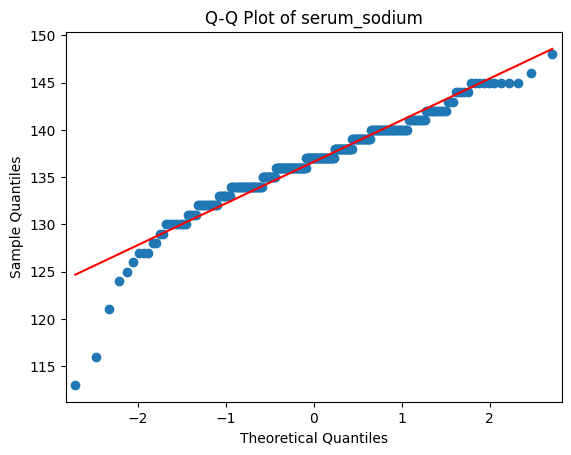

In [24]:
cols_to_transform = ['creatinine_phosphokinase', 'platelets', 'serum_creatinine']

# Apply Box-Cox transformation
for col in cols_to_transform:
    # Add a small constant to handle zeros if present
    data[col] = data[col] + 1e-6

    # Perform Box-Cox transformation
    data[col], _ = boxcox(data[col])

# Assess distribution of continuous variables
continuous_vars = ['age', 'creatinine_phosphokinase', 'ejection_fraction',
                   'platelets', 'serum_creatinine', 'serum_sodium']

for var in continuous_vars:
    plt.figure(figsize=(10, 5))  # Adjust figure size if needed

    # Histogram
    plt.subplot(1, 2, 1)
    sns.histplot(data[var], kde=True)  # kde adds a kernel density estimate
    plt.title(f'Distribution of {var}')
    plt.xlabel(var)
    plt.ylabel('Frequency')

# Assess distribution of residuals
for var in continuous_vars:
    plt.figure(figsize=(8, 6))

    # Q-Q plot
    sm.qqplot(data[var], line='s')  # 's' for standardized line
    plt.title(f'Q-Q Plot of {var}')
    plt.xlabel('Theoretical Quantiles')
    plt.ylabel('Sample Quantiles')

    plt.show()

**Logistic regression - 60-day mortality**

In [25]:
data_60d = data

# Creating variable for mortality within 60 days of admission
data_60d['hf_mortality_60d'] = np.where((data_60d['hf_mortality']==1) & (data_60d['time']<=60),1,0)

# Filtering data to those with >=60 day follow-up or mortality within 60 days
data_60d = data_60d.loc[(data_60d['hf_mortality_60d']==1) | (data_60d['time']>=60)]

data_60d

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,hypertension,platelets,serum_creatinine,serum_sodium,sex,smoking,time,hf_mortality,hf_mortality_60d
0,75.0,0,4.011877,0,20,1,935.540540,0.475058,130,1,0,4,1,1
1,55.0,0,4.790978,0,38,0,932.683294,0.090953,136,1,0,6,1,1
2,65.0,0,3.447415,0,20,0,734.259071,0.231062,129,1,1,7,1,1
3,50.0,1,3.320114,0,20,0,834.330337,0.475058,137,1,0,7,1,1
4,65.0,1,3.488730,1,20,0,1037.504702,0.632279,116,0,0,8,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,62.0,0,3.022089,1,38,1,718.460239,0.090953,143,1,1,270,0,0
295,55.0,0,4.392798,0,38,0,944.186147,0.166816,139,0,0,271,0,0
296,45.0,0,4.430194,1,60,0,1552.455897,-0.249707,138,0,0,278,0,0
297,45.0,0,4.476892,0,38,0,683.333908,0.286173,140,1,1,280,0,0


Split data into training and test sets

In [26]:
X_60d = data_60d[['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes', 'ejection_fraction', 'hypertension', 'platelets', 'serum_creatinine', 'serum_sodium', 'sex', 'smoking']]
y_60d = data_60d['hf_mortality_60d']

X_train_60d, X_test_60d, y_train_60d, y_test_60d = train_test_split(X_60d, y_60d, test_size=0.3, random_state=1)

Standardize variables

In [27]:
scaler = StandardScaler()
X_train_60d = scaler.fit_transform(X_train_60d)
X_test_60d = scaler.transform(X_test_60d)

Without penalization

In [28]:
log_reg_60d = LogisticRegression(solver='liblinear')
log_reg_60d.fit(X_train_60d, y_train_60d)

LogisticRegression(solver='liblinear')

In [29]:
# Use the model to make predictions on the testing data
y_pred_60d = log_reg_60d.predict(X_test_60d)

# Evaluate the model
conf_matrix = confusion_matrix(y_test_60d, y_pred_60d)
class_report = classification_report(y_test_60d, y_pred_60d)

print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)

Confusion Matrix:
[[69  4]
 [10  5]]

Classification Report:
              precision    recall  f1-score   support

           0       0.87      0.95      0.91        73
           1       0.56      0.33      0.42        15

    accuracy                           0.84        88
   macro avg       0.71      0.64      0.66        88
weighted avg       0.82      0.84      0.82        88



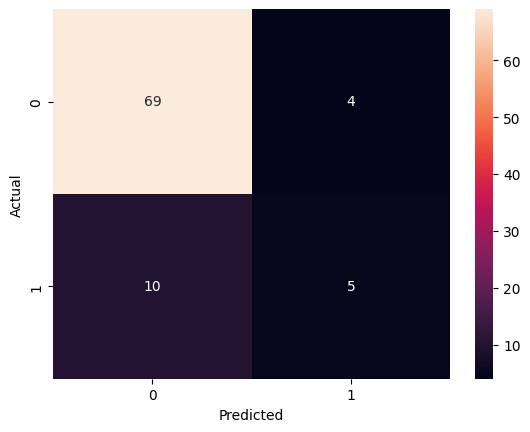

In [30]:
# Visualizing confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

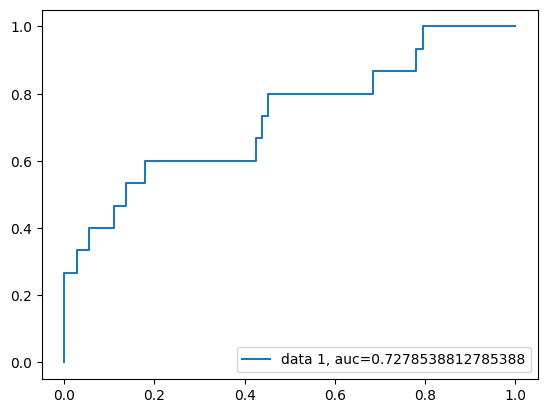

In [31]:
# ROC curve
y_pred_proba = log_reg_60d.predict_proba(X_test_60d)[::,1]
fpr, tpr, _ = roc_curve(y_test_60d,  y_pred_proba)
auc = roc_auc_score(y_test_60d, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [32]:
# Logistic regression - no penalization model summary

# Add a constant term for the intercept
X_60d = sm.add_constant(X_60d)

# Create and fit logistic regression model
log_reg_60d = sm.Logit(y_60d, X_60d).fit()

# Get summary report
summary = log_reg_60d.summary()
print(summary)

Optimization terminated successfully.
         Current function value: 0.399082
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:       hf_mortality_60d   No. Observations:                  291
Model:                          Logit   Df Residuals:                      279
Method:                           MLE   Df Model:                           11
Date:                Tue, 28 Jan 2025   Pseudo R-squ.:                  0.1681
Time:                        14:18:15   Log-Likelihood:                -116.13
converged:                       True   LL-Null:                       -139.60
Covariance Type:            nonrobust   LLR p-value:                 2.206e-06
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                        0.1589      5.206      0.031      0.976     -10.046

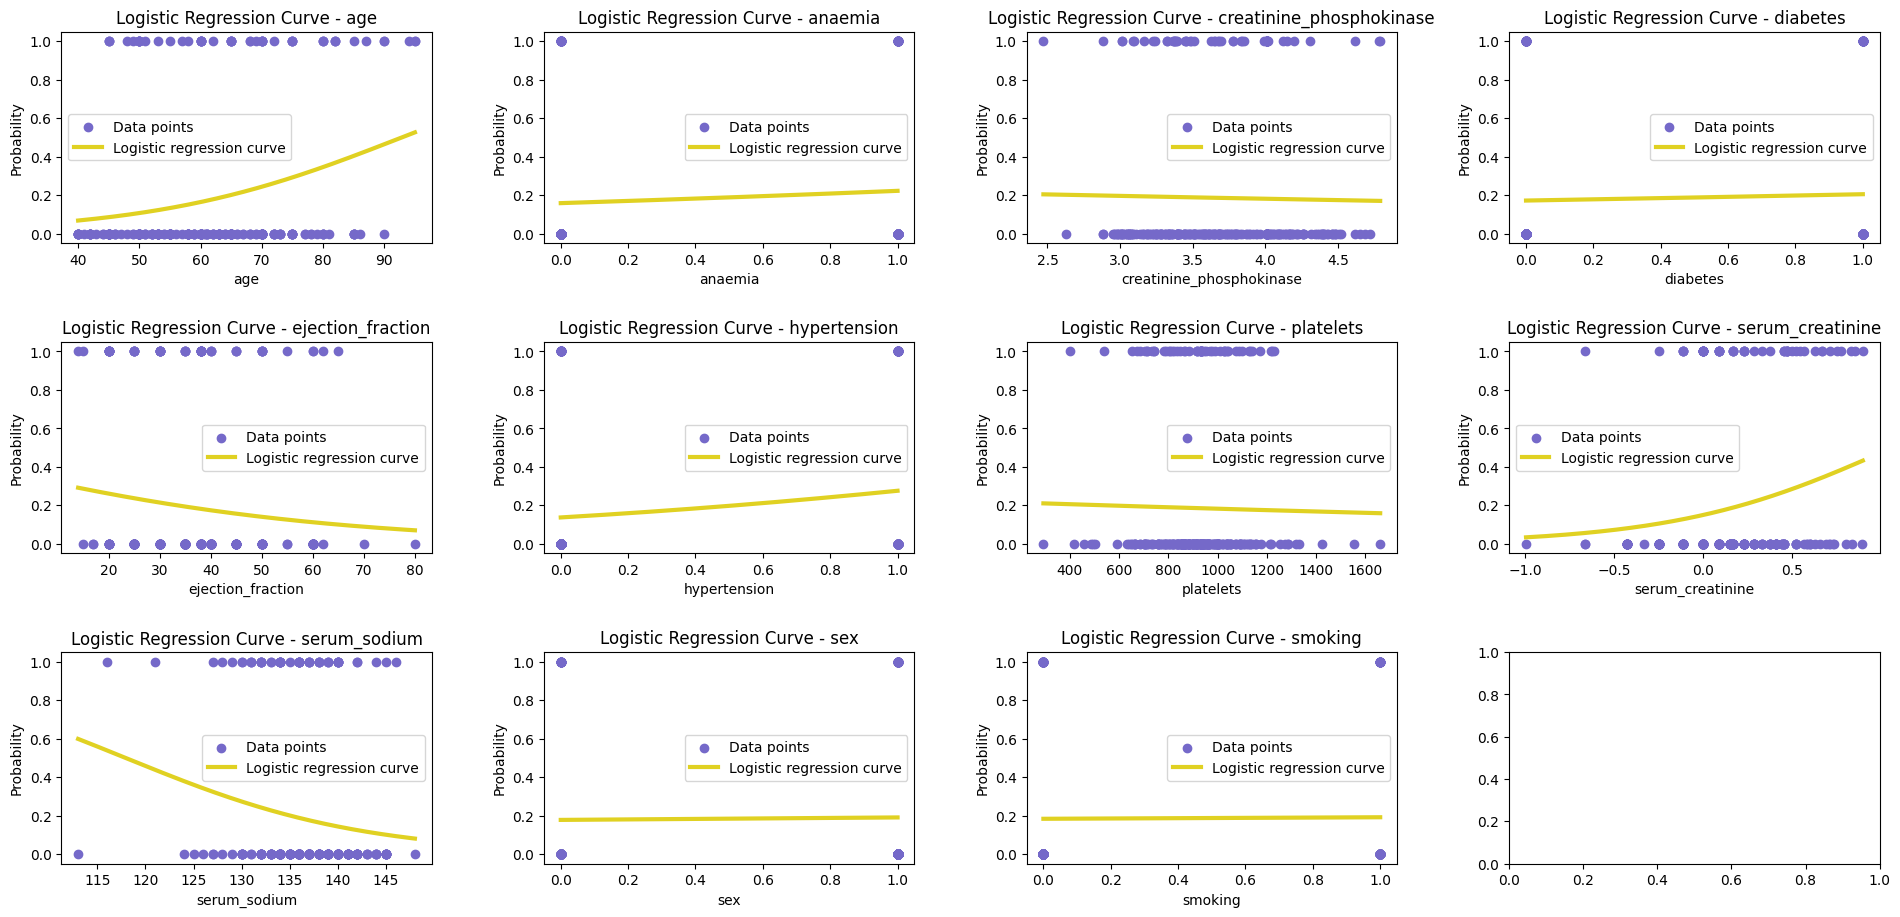

In [33]:
# Exploration of logistic regression features
log_reg_60d = LogisticRegression()

fig, axs = plt.subplots(3, 4, figsize=(20, 10))
fig.tight_layout(pad=5.0)  # Adds padding between subplots

for i, feature in enumerate(data_60d.columns[:-3]):  # Exclude 'hf_mortality' and 'time' columns
    row = i // 4  # Determine row index
    col = i % 4   # Determine column index

    # Reshape the feature and outcome arrays to fit the model
    X = data_60d[[feature]]
    y = data_60d['hf_mortality_60d']

    # Fit logistic regression model
    log_reg_60d.fit(X, y)

    # Get min and max values of the feature for plotting
    x_test = np.linspace(X.min(), X.max(), 300)

    # Get the probability for each value in the range
    prob = log_reg_60d.predict_proba(x_test)[:, 1]

    # Plot the data points
    axs[row, col].scatter(X, y, color='#7569c9', label='Data points')

    # Plot the sigmoid curve
    axs[row, col].plot(x_test, prob, color='#e0d122', lw=3, label='Logistic regression curve' )

    axs[row, col].set_title(f'Logistic Regression Curve - {feature}')
    axs[row, col].set_xlabel(feature)
    axs[row, col].set_ylabel('Probability')
    axs[row, col].legend()

plt.show()

With L1 penalization (to simplify model given many features with minimal correlation with outcome)

In [34]:
# Identifying the optimal penalization value for C

# Define the parameter grid for C
param_grid = {'C': [0.0001, 0.00025, 0.0005, 0.001, 0.0025, 0.005, 0.007, 0.01, 0.025, 0.05, 0.075, 0.0775, 0.08, 0.085, 0.1, 0.15, 0.2, 1, 10, 100]}

# Create and train a Logistic Regression model for 60-day mortality
model_60 = LogisticRegression()
grid_search_60 = GridSearchCV(model_60, param_grid, scoring='neg_mean_squared_error', cv=5)
grid_search_60.fit(X_train_60d, y_train_60d)
best_c_60 = grid_search_60.best_params_['C']

# Print the best value of C for 60-day mortality
print("Best value of C for 60-day mortality:", best_c_60)

Best value of C for 60-day mortality: 0.2


In [35]:
# Create logistic regression model with optimal L1 penalization C value
log_reg_60d_l1 = LogisticRegression(penalty='l1', C=best_c_60, solver='liblinear')
log_reg_60d_l1.fit(X_train_60d, y_train_60d)

# Use the model to make predictions on the testing data
y_pred_60d = log_reg_60d_l1.predict(X_test_60d)

# Evaluate the model
conf_matrix = confusion_matrix(y_test_60d, y_pred_60d)
class_report = classification_report(y_test_60d, y_pred_60d)

print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)

Confusion Matrix:
[[73  0]
 [12  3]]

Classification Report:
              precision    recall  f1-score   support

           0       0.86      1.00      0.92        73
           1       1.00      0.20      0.33        15

    accuracy                           0.86        88
   macro avg       0.93      0.60      0.63        88
weighted avg       0.88      0.86      0.82        88



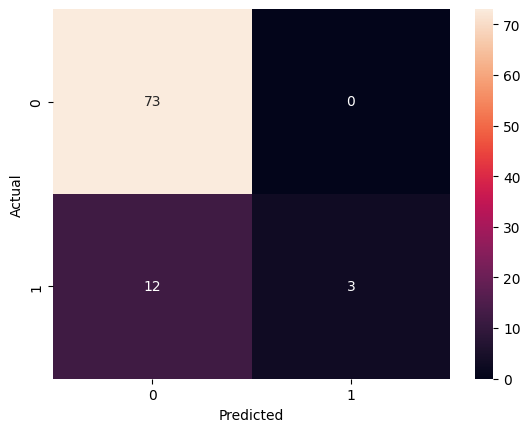

In [36]:
# Visualizing confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [37]:
# Logistic regression - L1 penalization model summary

# Create and fit logistic regression model
log_reg_60d_l1 = sm.Logit(y_60d, X_60d)
res=log_reg_60d_l1.fit_regularized(method='l1', alpha=best_c_60)
log_reg_60d_l1 = log_reg_60d_l1.fit(params=res.params)

# Get summary report
summary = log_reg_60d_l1.summary()
print(summary)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.40215180875800083
            Iterations: 67
            Function evaluations: 79
            Gradient evaluations: 67
Optimization terminated successfully.
         Current function value: 0.399082
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:       hf_mortality_60d   No. Observations:                  291
Model:                          Logit   Df Residuals:                      279
Method:                           MLE   Df Model:                           11
Date:                Tue, 28 Jan 2025   Pseudo R-squ.:                  0.1681
Time:                        14:18:18   Log-Likelihood:                -116.13
converged:                       True   LL-Null:                       -139.60
Covariance Type:            nonrobust   LLR p-value:                 2.206e-06
                               coef    std err         

With L2 penalization (given small number of predictor variables)

In [38]:
# Create logistic regression model with optimal L2 penalization C value
log_reg_60d_l2 = LogisticRegression(penalty='l2', C=best_c_60, solver='liblinear')
log_reg_60d_l2.fit(X_train_60d, y_train_60d)

# Use the model to make predictions on the testing data
y_pred_60d = log_reg_60d_l2.predict(X_test_60d)

# Evaluate the model
conf_matrix = confusion_matrix(y_test_60d, y_pred_60d)
class_report = classification_report(y_test_60d, y_pred_60d)

print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)

Confusion Matrix:
[[71  2]
 [10  5]]

Classification Report:
              precision    recall  f1-score   support

           0       0.88      0.97      0.92        73
           1       0.71      0.33      0.45        15

    accuracy                           0.86        88
   macro avg       0.80      0.65      0.69        88
weighted avg       0.85      0.86      0.84        88



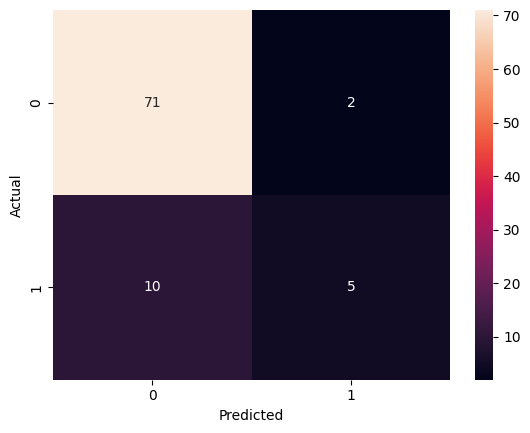

In [39]:
# Visualizing confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

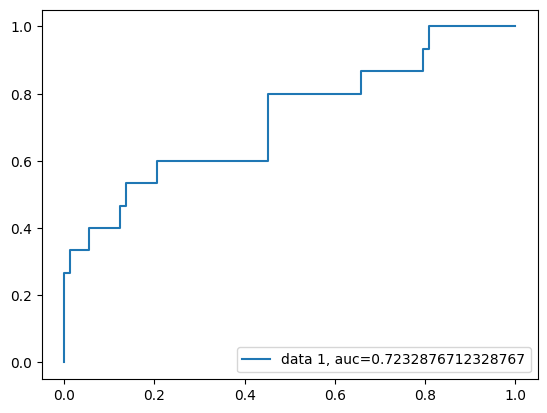

In [40]:
# ROC curve
y_pred_proba = log_reg_60d_l2.predict_proba(X_test_60d)[::,1]
fpr, tpr, _ = roc_curve(y_test_60d,  y_pred_proba)
auc = roc_auc_score(y_test_60d, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [41]:
# Logistic regression - L2 penalization model summary

# Create and fit logistic regression model
log_reg_60d_l2 = sm.Logit(y_60d, X_60d)
res=log_reg_60d_l2.fit_regularized(alpha=best_c_60, L1_wt=0)
log_reg_60d_l2 = log_reg_60d_l2.fit(params=res.params)

# Get summary report
summary = log_reg_60d_l2.summary()
print(summary)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.40215180875800083
            Iterations: 67
            Function evaluations: 79
            Gradient evaluations: 67
Optimization terminated successfully.
         Current function value: 0.399082
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:       hf_mortality_60d   No. Observations:                  291
Model:                          Logit   Df Residuals:                      279
Method:                           MLE   Df Model:                           11
Date:                Tue, 28 Jan 2025   Pseudo R-squ.:                  0.1681
Time:                        14:18:19   Log-Likelihood:                -116.13
converged:                       True   LL-Null:                       -139.60
Covariance Type:            nonrobust   LLR p-value:                 2.206e-06
                               coef    std err         

In [42]:
# Sensitivity
5/(5+10)

0.3333333333333333

In [43]:
# Specificity
71/(71+2)

0.9726027397260274

In [44]:

# PPV
5/(5+2)

0.7142857142857143

In [45]:
# NPV
71/(71+10)

0.8765432098765432

**Logistic regression - 30-day mortality**

In [46]:
data_30d = data

# Creating variable for mortality within 30 days of admission
data_30d['hf_mortality_30d'] = np.where((data_30d['hf_mortality']==1) & (data_30d['time']<=30),1,0)

# Filtering data to those with >=30 day follow-up or mortality within 30 days
data_30d = data_30d.loc[(data_30d['hf_mortality_30d']==1) | (data_30d['time']>=30)]

data_30d

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,hypertension,platelets,serum_creatinine,serum_sodium,sex,smoking,time,hf_mortality,hf_mortality_60d,hf_mortality_30d
0,75.0,0,4.011877,0,20,1,935.540540,0.475058,130,1,0,4,1,1,1
1,55.0,0,4.790978,0,38,0,932.683294,0.090953,136,1,0,6,1,1,1
2,65.0,0,3.447415,0,20,0,734.259071,0.231062,129,1,1,7,1,1,1
3,50.0,1,3.320114,0,20,0,834.330337,0.475058,137,1,0,7,1,1,1
4,65.0,1,3.488730,1,20,0,1037.504702,0.632279,116,0,0,8,1,1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
294,62.0,0,3.022089,1,38,1,718.460239,0.090953,143,1,1,270,0,0,0
295,55.0,0,4.392798,0,38,0,944.186147,0.166816,139,0,0,271,0,0,0
296,45.0,0,4.430194,1,60,0,1552.455897,-0.249707,138,0,0,278,0,0,0
297,45.0,0,4.476892,0,38,0,683.333908,0.286173,140,1,1,280,0,0,0


Split data into training and test sets

In [47]:
X_30d = data_30d[['age', 'anaemia', 'creatinine_phosphokinase', 'diabetes', 'ejection_fraction', 'hypertension', 'platelets', 'serum_creatinine', 'serum_sodium', 'sex', 'smoking']]
y_30d = data_30d['hf_mortality_60d']
X_train_30d, X_test_30d, y_train_30d, y_test_30d = train_test_split(X_30d, y_30d, test_size=0.3, random_state=1)

Standardize variables

In [48]:
scaler = StandardScaler()
X_train_30d = scaler.fit_transform(X_train_30d)
X_test_30d = scaler.transform(X_test_30d)

Without penalization

In [49]:
log_reg_30d = LogisticRegression(solver='liblinear')
log_reg_30d.fit(X_train_30d, y_train_30d)

LogisticRegression(solver='liblinear')

In [50]:
# Use the model to make predictions on the testing data
y_pred_30d = log_reg_30d.predict(X_test_30d)

# Evaluate the model
conf_matrix = confusion_matrix(y_test_30d, y_pred_30d)
class_report = classification_report(y_test_30d, y_pred_30d)

print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)

Confusion Matrix:
[[75  1]
 [ 9  4]]

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.99      0.94        76
           1       0.80      0.31      0.44        13

    accuracy                           0.89        89
   macro avg       0.85      0.65      0.69        89
weighted avg       0.88      0.89      0.87        89



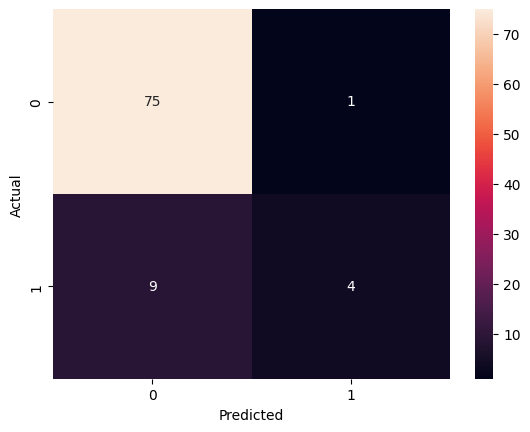

In [51]:
# Visualizing confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

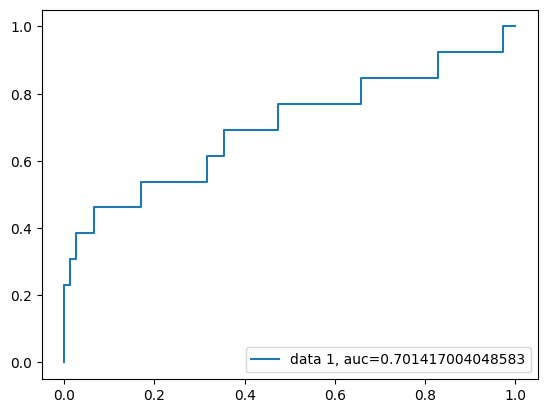

In [52]:
# ROC curve
y_pred_proba = log_reg_30d.predict_proba(X_test_30d)[::,1]
fpr, tpr, _ = roc_curve(y_test_30d,  y_pred_proba)
auc = roc_auc_score(y_test_30d, y_pred_proba)
plt.plot(fpr,tpr,label="data 1, auc="+str(auc))
plt.legend(loc=4)
plt.show()

In [53]:
# Logistic regression - no penalization model summary

# Add a constant term for the intercept
X_30d = sm.add_constant(X_30d)

# Create and fit logistic regression model
log_reg_30d = sm.Logit(y_30d, X_30d).fit()

# Get summary report
summary = log_reg_30d.summary()
print(summary)

Optimization terminated successfully.
         Current function value: 0.397008
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:       hf_mortality_60d   No. Observations:                  295
Model:                          Logit   Df Residuals:                      283
Method:                           MLE   Df Model:                           11
Date:                Tue, 28 Jan 2025   Pseudo R-squ.:                  0.1659
Time:                        14:18:19   Log-Likelihood:                -117.12
converged:                       True   LL-Null:                       -140.42
Covariance Type:            nonrobust   LLR p-value:                 2.534e-06
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
const                        0.3956      5.201      0.076      0.939      -9.797

With L1 penalization (to simplify model given many features with minimal correlation with outcome)

In [54]:
# Identifying the optimal penalization value for C

# Define the parameter grid for C
param_grid = {'C': [0.0001, 0.00025, 0.0005, 0.001, 0.0025, 0.005, 0.007, 0.01, 0.025, 0.05, 0.075, 0.0775, 0.08, 0.085, 0.1, 0.15, 0.2, 1, 10, 100]}

# Create and train a Logistic Regression model for 60-day mortality
model_30 = LogisticRegression()
grid_search_30 = GridSearchCV(model_30, param_grid, scoring='neg_mean_squared_error', cv=5)
grid_search_30.fit(X_train_30d, y_train_30d)
best_c_30 = grid_search_30.best_params_['C']

# Print the best value of C for 30-day mortality
print("Best value of C for 30-day mortality:", best_c_30)

Best value of C for 30-day mortality: 0.0775


In [55]:
# Create logistic regression model with optimal L1 penalization C value
log_reg_30d_l1 = LogisticRegression(penalty='l1', C=best_c_30, solver='liblinear')
log_reg_30d_l1.fit(X_train_30d, y_train_30d)

# Use the model to make predictions on the testing data
y_pred_30d = log_reg_30d_l1.predict(X_test_30d)

# Evaluate the model
conf_matrix = confusion_matrix(y_test_30d, y_pred_30d)
class_report = classification_report(y_test_30d, y_pred_30d)

print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)

Confusion Matrix:
[[76  0]
 [13  0]]

Classification Report:
              precision    recall  f1-score   support

           0       0.85      1.00      0.92        76
           1       0.00      0.00      0.00        13

    accuracy                           0.85        89
   macro avg       0.43      0.50      0.46        89
weighted avg       0.73      0.85      0.79        89



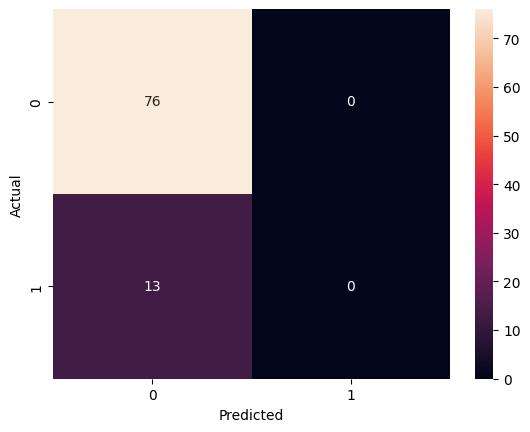

In [56]:
# Visualizing confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [57]:
# Logistic regression - L1 penalization model summary

# Create and fit logistic regression model
log_reg_30d_l1 = sm.Logit(y_30d, X_30d)
res=log_reg_30d_l1.fit_regularized(method='l1', alpha=best_c_30)
log_reg_30d_l1 = log_reg_30d_l1.fit(params=res.params)

# Get summary report
summary = log_reg_30d_l1.summary()
print(summary)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.39820780746527706
            Iterations: 90
            Function evaluations: 101
            Gradient evaluations: 90
Optimization terminated successfully.
         Current function value: 0.397008
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:       hf_mortality_60d   No. Observations:                  295
Model:                          Logit   Df Residuals:                      283
Method:                           MLE   Df Model:                           11
Date:                Tue, 28 Jan 2025   Pseudo R-squ.:                  0.1659
Time:                        14:18:20   Log-Likelihood:                -117.12
converged:                       True   LL-Null:                       -140.42
Covariance Type:            nonrobust   LLR p-value:                 2.534e-06
                               coef    std err        

With L2 penalization (given small number of predictor variables)

In [58]:
# Create logistic regression model with optimal L2 penalization C value
log_reg_30d_l2 = LogisticRegression(penalty='l2', C=best_c_30, solver='liblinear')
log_reg_30d_l2.fit(X_train_30d, y_train_30d)

# Use the model to make predictions on the testing data
y_pred_30d = log_reg_30d_l2.predict(X_test_30d)

# Evaluate the model
conf_matrix = confusion_matrix(y_test_30d, y_pred_30d)
class_report = classification_report(y_test_30d, y_pred_30d)

print("Confusion Matrix:")
print(conf_matrix)
print("\nClassification Report:")
print(class_report)

Confusion Matrix:
[[75  1]
 [ 9  4]]

Classification Report:
              precision    recall  f1-score   support

           0       0.89      0.99      0.94        76
           1       0.80      0.31      0.44        13

    accuracy                           0.89        89
   macro avg       0.85      0.65      0.69        89
weighted avg       0.88      0.89      0.87        89



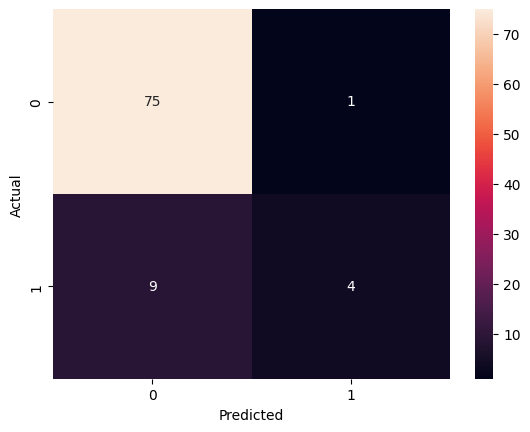

In [59]:
# Visualizing confusion matrix
sns.heatmap(conf_matrix, annot=True, fmt='d')
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [60]:
# Logistic regression - L2 penalization model summary

# Create and fit logistic regression model
log_reg_30d_l2 = sm.Logit(y_30d, X_30d)
res=log_reg_30d_l2.fit_regularized(alpha=best_c_30, L1_wt=0)
log_reg_30d_l2 = log_reg_30d_l2.fit(params=res.params)

# Get summary report
summary = log_reg_30d_l2.summary()
print(summary)

Optimization terminated successfully    (Exit mode 0)
            Current function value: 0.39820780746527706
            Iterations: 90
            Function evaluations: 101
            Gradient evaluations: 90
Optimization terminated successfully.
         Current function value: 0.397008
         Iterations 7
                           Logit Regression Results                           
Dep. Variable:       hf_mortality_60d   No. Observations:                  295
Model:                          Logit   Df Residuals:                      283
Method:                           MLE   Df Model:                           11
Date:                Tue, 28 Jan 2025   Pseudo R-squ.:                  0.1659
Time:                        14:18:21   Log-Likelihood:                -117.12
converged:                       True   LL-Null:                       -140.42
Covariance Type:            nonrobust   LLR p-value:                 2.534e-06
                               coef    std err        